In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df= pd.read_csv('./RSCCASN.csv', parse_dates=True, index_col='DATE')
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


<AxesSubplot: xlabel='DATE'>

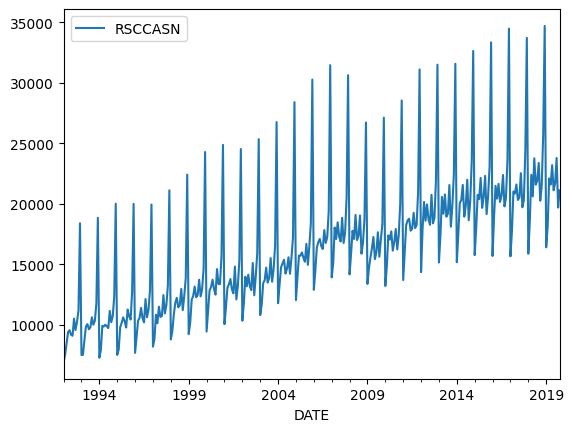

In [3]:
df.plot()

In [4]:
#our data is yearly basis, so we'll train our model for 1.5 years. 1.5 years = 18 months
#as our rows are on monthly basis, so we'll test set of 18 rows

train = df[:len(df)-18]
test = df[len(df)-18:]


In [5]:
#scaling our data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)


In [6]:
# generators
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator

length= 12
batch_size=1
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)


In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')


In [8]:
from keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(patience=5)
model.fit(generator, validation_data=validation_generator, callbacks=[early_stopping], epochs=10)


Epoch 1/10
304/304 [==============================] - 6s 9ms/step - loss: 0.0427 - val_loss: 0.0051
Epoch 2/10
304/304 [==============================] - 3s 8ms/step - loss: 0.0184 - val_loss: 0.0026
Epoch 3/10
304/304 [==============================] - 2s 8ms/step - loss: 0.0164 - val_loss: 0.0143
Epoch 4/10
304/304 [==============================] - 2s 8ms/step - loss: 0.0123 - val_loss: 0.0102
Epoch 5/10
304/304 [==============================] - 2s 8ms/step - loss: 0.0074 - val_loss: 0.0056
Epoch 6/10
304/304 [==============================] - 3s 10ms/step - loss: 0.0058 - val_loss: 0.0026
Epoch 7/10
304/304 [==============================] - 3s 10ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 8/10
304/304 [==============================] - 3s 8ms/step - loss: 0.0024 - val_loss: 3.7617e-04
Epoch 9/10
304/304 [==============================] - 3s 10ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 10/10
304/304 [==============================] - 2s 8ms/step - loss: 0.0019 - val_loss:

<AxesSubplot: >

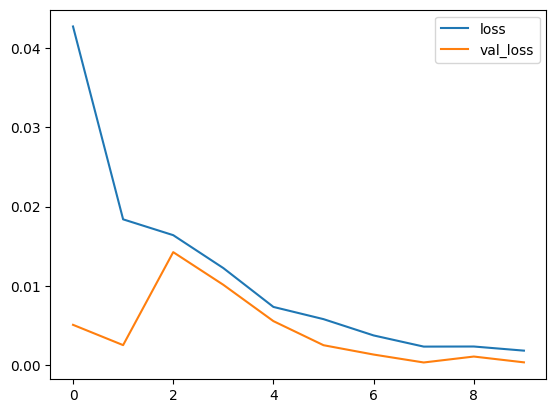

In [9]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [10]:
#evaluation
test_predictions= []
initial_batch= scaled_train[-length:]
current_batch = initial_batch.reshape((1,length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 42ms/step


In [11]:
true_preds = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_preds

C:\Users\dell\AppData\Local\Temp\ipykernel_11228\2086401050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_preds


<AxesSubplot: xlabel='DATE'>

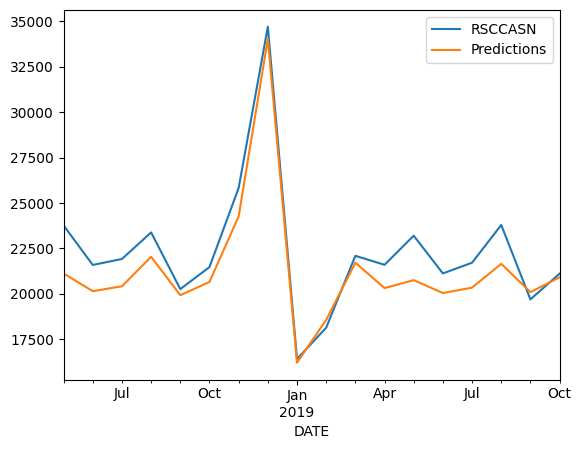

In [12]:
test.plot()

In [13]:
#now forecasting into the unknown future
full_scaler = MinMaxScaler()
full_scaled_data = full_scaler.fit_transform(df)


In [14]:
generator = TimeseriesGenerator(full_scaled_data,full_scaled_data,length=length,batch_size=1)

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [15]:
model.fit(generator, callbacks=[early_stopping], epochs=15)

Epoch 1/15
322/322 [==============================] - 6s 9ms/step - loss: 0.0270
Epoch 2/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0197
Epoch 3/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0179
Epoch 4/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0147
Epoch 5/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0076
Epoch 6/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0043
Epoch 7/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0034
Epoch 8/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0025
Epoch 9/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0023
Epoch 10/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0015
Epoch 11/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0018
Epoch 12/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0017
Epoch 13/15
322/322 [=

In [16]:
test_predictions= []
initial_batch= full_scaled_data[-length:]
current_batch = initial_batch.reshape((1,length, n_features))

for i in range(12):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 64ms/step


<AxesSubplot: xlabel='DATE'>

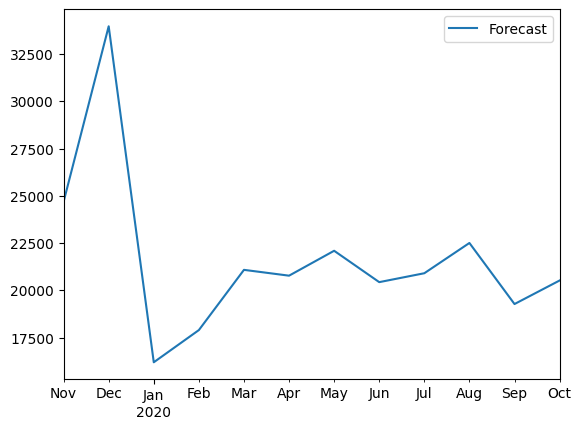

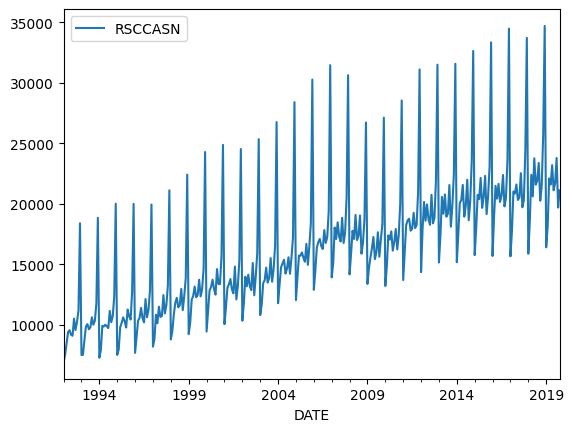

In [17]:
true_preds= full_scaler.inverse_transform(test_predictions)

forecast_index = pd.date_range(start='2019-11-01', periods=12, freq='MS')   #MS month start
forecast_df = pd.DataFrame(data=true_preds, index=forecast_index, columns=['Forecast'])
forecast_df.plot()
df.plot()

<AxesSubplot: xlabel='DATE'>

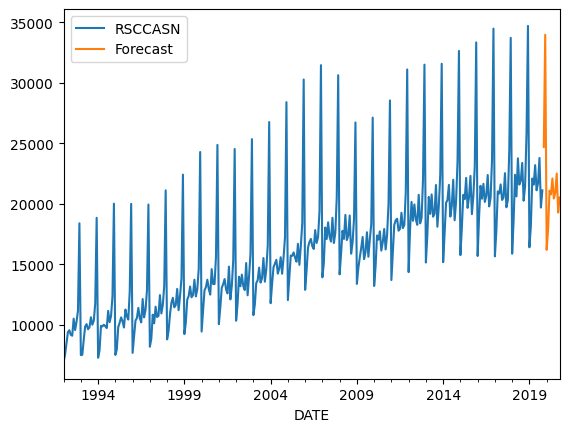

In [18]:
ax= df.plot()
forecast_df.plot(ax=ax)